In [1]:
import json
from pathlib import Path
from statsmodels.stats.weightstats import DescrStatsW
import numpy as np


#results_dir = Path('/projects/self_supervised/results/distillation_experiment')
results_dir = Path('/projects/self_supervised/results/distillation_experiment_weighted_loss')


def read_metrics(path):
    with open(path,'r') as f:
        metrics = json.load(f)
    return metrics

def conf_interval(list_values):
    d_stats = DescrStatsW(list_values)
    d_mean = d_stats.mean
    alpha = 0.05
    d_conf_int = d_stats.tconfint_mean(alpha=alpha) 
    return d_conf_int[0], d_conf_int[1]

model_list = ['student_18','student_50','teacher']
metrics_list = ['acc','f1','sensitivity','specificity','ppv','npv','auc']

metrics_dict = {
    model:{m:[] for m in metrics_list} for model in model_list
}

for split in list(results_dir.iterdir())[:]:
    for model in model_list:
        metrics_model = read_metrics(split.joinpath(f'metrics_{model}.json'))
        for m in metrics_list:
            metrics_dict[model][m].append(metrics_model[m])


In [2]:
avrg_metrics_dict = {}
for model in model_list:
    print(model)
    avrg_metrics_dict.update({model:{k:{} for k in metrics_list}})
    for m in metrics_list:
        arr = np.array(metrics_dict[model][m])   
        mean = arr.mean()
        conf_min,conf_max = conf_interval(arr)
        print(f'{m}: {mean:.3f}+-{conf_min:.3f}, {conf_max:.3f}')
        avrg_metrics_dict[model][m].update({'mean':mean,'conf_min':conf_min,'conf_max':conf_max})
        
    print('\n')

student_18
acc: 0.522+-0.454, 0.590
f1: 0.483+-0.425, 0.541
sensitivity: 0.541+-0.383, 0.699
specificity: 0.514+-0.365, 0.664
ppv: 0.322+-0.282, 0.362
npv: 0.722+-0.686, 0.758
auc: 0.528+-0.490, 0.566


student_50
acc: 0.543+-0.454, 0.632
f1: 0.480+-0.404, 0.556
sensitivity: 0.522+-0.320, 0.723
specificity: 0.554+-0.345, 0.762
ppv: 0.346+-0.293, 0.400
npv: 0.663+-0.496, 0.831
auc: 0.538+-0.514, 0.562


teacher
acc: 0.571+-0.543, 0.599
f1: 0.526+-0.497, 0.554
sensitivity: 0.445+-0.388, 0.502
specificity: 0.625+-0.587, 0.663
ppv: 0.335+-0.301, 0.369
npv: 0.726+-0.704, 0.748
auc: 0.535+-0.504, 0.565




In [3]:
avrg_metrics_dict

{'student_18': {'acc': {'mean': 0.5218749999999999,
   'conf_min': 0.45417394046371357,
   'conf_max': 0.5895760595362864},
  'f1': {'mean': 0.4827271154651684,
   'conf_min': 0.42467884725491467,
   'conf_max': 0.5407753836754223},
  'sensitivity': {'mean': 0.5411330049261084,
   'conf_min': 0.383073165390753,
   'conf_max': 0.6991928444614638},
  'specificity': {'mean': 0.5144424934152766,
   'conf_min': 0.36463773990756887,
   'conf_max': 0.6642472469229843},
  'ppv': {'mean': 0.32215893438507176,
   'conf_min': 0.28243254441155996,
   'conf_max': 0.36188532435858356},
  'npv': {'mean': 0.7220786517340563,
   'conf_min': 0.6857478896739584,
   'conf_max': 0.7584094137941539},
  'auc': {'mean': 0.5277877491706924,
   'conf_min': 0.49004086065511687,
   'conf_max': 0.5655346376862679}},
 'student_50': {'acc': {'mean': 0.5427083333333333,
   'conf_min': 0.4536032077126806,
   'conf_max': 0.6318134589539861},
  'f1': {'mean': 0.4802044646806437,
   'conf_min': 0.4040795137326735,
   'co

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


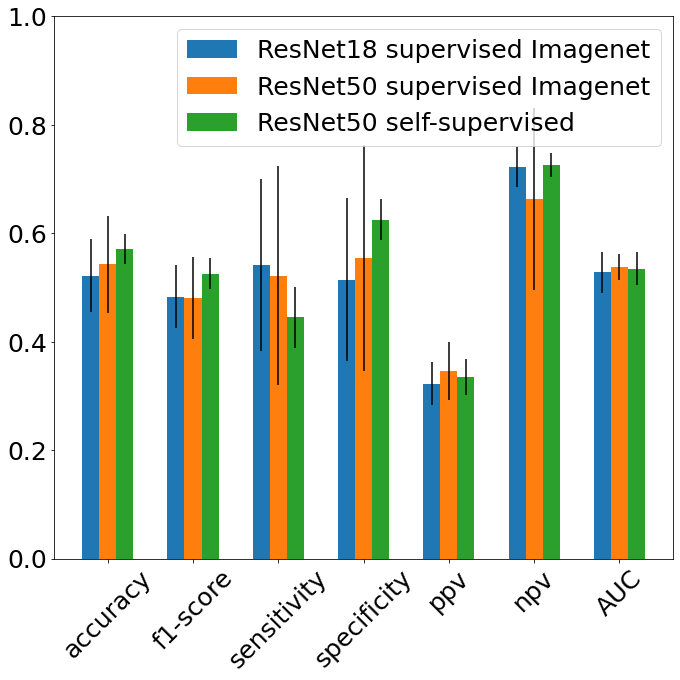

In [4]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np


def get_mean_and_error_scores(model_name,metrics_list,avrg_metrics_dict):
    
    means = [avrg_metrics_dict[model_name][m]['mean'] for m in metrics_list]
    low_error = [avrg_metrics_dict[model_name][m]['mean'] - avrg_metrics_dict[model_name][m]['conf_min'] for m in metrics_list]
    up_error = [avrg_metrics_dict[model_name][m]['conf_max'] - avrg_metrics_dict[model_name][m]['mean'] for m in metrics_list]
    errors = [low_error,up_error]
    return means, errors
    

resnet18_means,resnet18_errors = get_mean_and_error_scores('student_18',metrics_list,avrg_metrics_dict)
resnet50_means,resnet50_errors = get_mean_and_error_scores('student_50',metrics_list,avrg_metrics_dict)
resnetteacher_means,resnetteacher_errors = get_mean_and_error_scores('teacher',metrics_list,avrg_metrics_dict)


from matplotlib import rcParams
rcParams['font.size'] = 25
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Tahoma']

x = np.arange(len(metrics_list))  # the label locations
width = 0.2  # the width of the bars
fig, ax = plt.subplots(figsize=(10,10))

metrics_list[metrics_list.index('acc')] = 'accuracy'
metrics_list[metrics_list.index('f1')] = 'f1-score'
metrics_list[metrics_list.index('auc')] = 'AUC'


rects1 = ax.bar(x-width, resnet18_means, width, label='ResNet18 supervised Imagenet',yerr = resnet18_errors,bottom=0.0)
rects2 = ax.bar(x , resnet50_means, width, label='ResNet50 supervised Imagenet',yerr = resnet50_errors,bottom=0.0)
rects3 = ax.bar(x + width, resnetteacher_means, width, label='ResNet50 self-supervised',yerr = resnetteacher_errors,bottom=0.0)

ax.set_xticks(x)
ax.set_xticklabels(metrics_list,rotation=45)
ax.legend()
ax.set_ylim([0.0,1.0])
fig.tight_layout()
plt.show()

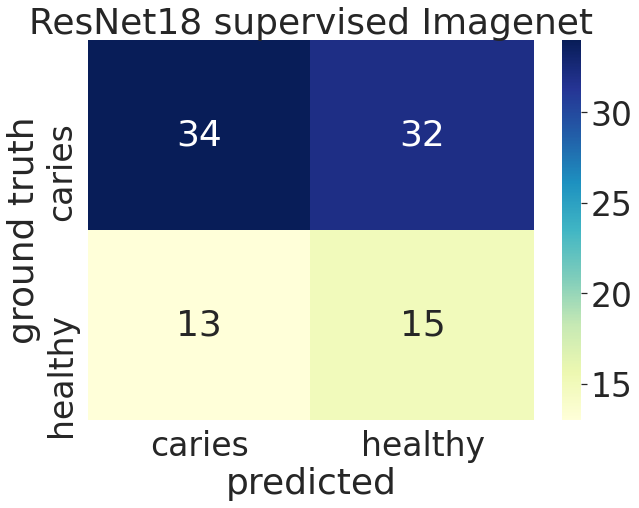

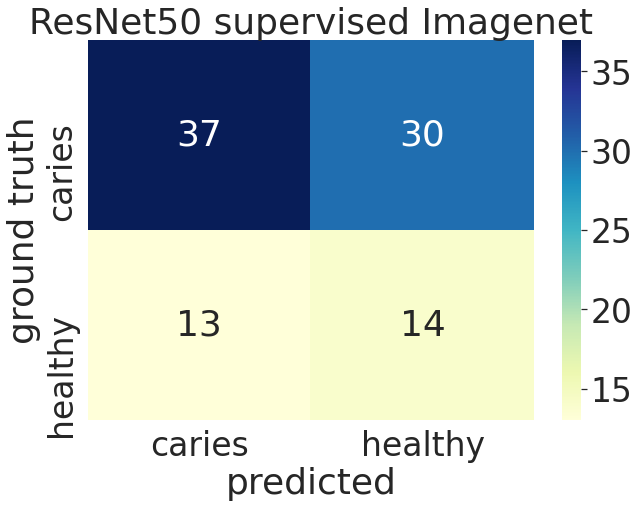

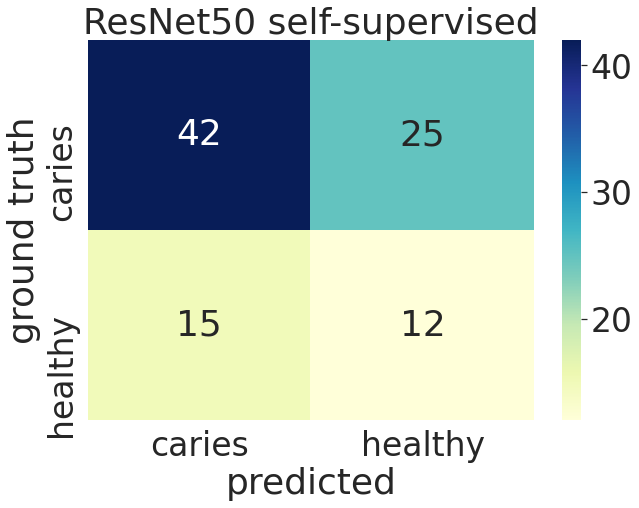

In [5]:
#confusion matrix

import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt


def plot_conf_matrix(array,columns,font_scale=3,title = ''):

    df_cm = pd.DataFrame(array, index = columns,
                      columns = columns)

    sn.set(font_scale=font_scale)  # crazy big
    plt.figure(figsize = (10,7))
    sn.heatmap(df_cm, annot=True,cmap="YlGnBu",fmt="d")
    plt.xlabel('predicted')
    plt.ylabel('ground truth')
    plt.title(title)

# to do: read class index dict
import sys

sys.path.append('../src')

from utilities import *


imgs,labels = parse_dataset(Path('/projects/self_supervised/data/bitewings_caries/bw_L'))
labels, class_index_dict = label_encoding(labels)

#print(class_index_dict)


#load metrics
#read_metrics(results_path)
metrics_list = ['TN','TP','FP','FN']
metrics_dict = {model:{metric:None for metric in metrics_list} for model in model_list}
for model in model_list:
    TN = 0
    TP = 0
    FN = 0
    FP = 0
    
    n_splits = len([res for res in results_dir.iterdir()])
    for split_path in results_dir.iterdir():
        #split_path = results_dir.joinpath('split_2')
        metrics_model = read_metrics(split_path.joinpath(f'metrics_{model}.json'))
        TN += metrics_model['TN']
        TP += metrics_model['TP']
        FN += metrics_model['FN']
        FP += metrics_model['FP']
        
    TN /= n_splits
    TP /= n_splits
    FN /= n_splits
    FP /= n_splits
        
          
    #print(metrics_model)
        
    metrics_dict[model] = {'TN':int(TN),'TP':int(TP),'FN':int(FN),'FP':int(FP)}
       

model_conv_dict = {
    'student_18':'ResNet18 supervised Imagenet',
    'student_50':'ResNet50 supervised Imagenet',
    'teacher':'ResNet50 self-supervised',
    
}

for model in metrics_dict.keys():
    TN = metrics_dict[model]['TN']
    TP = metrics_dict[model]['TP']
    FN = metrics_dict[model]['FN']
    FP = metrics_dict[model]['FP']
    conf_matrix = np.array([[ TN, FP],
                            [ FN, TP]])
    
    plot_conf_matrix(conf_matrix,[v for k,v in class_index_dict.items()],title=model_conv_dict[model])

In [6]:
# to do: average confusion matrix





In [7]:
import cv2
import torch
import numpy as np
from PIL import Image

class InfoHolder():

    def __init__(self, heatmap_layer):
        self.gradient = None
        self.activation = None
        self.heatmap_layer = heatmap_layer

    def get_gradient(self, grad):
        self.gradient = grad

    def hook(self, model, input, output):
        output.register_hook(self.get_gradient)
        self.activation = output.detach()

def generate_heatmap(weighted_activation):
    raw_heatmap = torch.mean(weighted_activation, 0)
    heatmap = np.maximum(raw_heatmap.detach().cpu(), 0)
    heatmap /= torch.max(heatmap) + 1e-10
    return heatmap.numpy()

def superimpose(input_img, heatmap):
    img = cv2.cvtColor(input_img,cv2.COLOR_BGR2RGB)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = np.uint8(heatmap * 0.6 + img * 0.4)
    pil_img = cv2.cvtColor(superimposed_img,cv2.COLOR_BGR2RGB)
    return pil_img

def to_RGB(tensor):
    tensor = (tensor - tensor.min())
    tensor = tensor/(tensor.max() + 1e-10)
    image_binary = np.transpose(tensor.numpy(), (1, 2, 0))
    image = np.uint8(255 * image_binary)
    return image

def grad_cam(model, image, heatmap_layer, transform, device, truelabel=None):
    
    input_tensor = transform(image)
    input_tensor = input_tensor.to(device)
    info = InfoHolder(heatmap_layer)
    heatmap_layer.register_forward_hook(info.hook)
    output = model(input_tensor.unsqueeze(0))
    print(output.shape)
    truelabel = truelabel if truelabel else torch.argmax(output)
    output[truelabel].backward()
    weights = torch.mean(info.gradient, [0, 2, 3])
    activation = info.activation.squeeze(0)
    weighted_activation = torch.zeros(activation.shape)
    for idx, (weight, activation) in enumerate(zip(weights, activation)):
        weighted_activation[idx] = weight * activation

    heatmap = generate_heatmap(weighted_activation)
    
    return superimpose(np.asarray(image),heatmap), truelabel.item(), output[truelabel].item()

torch.Size([2])


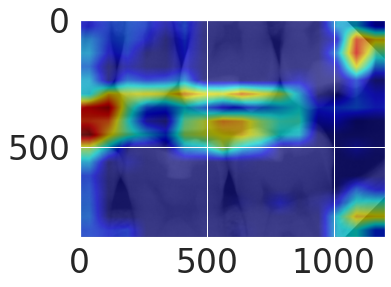

In [8]:
#gradcam

from PIL import Image
import torch
import torchvision
import torchvision.transforms as transforms

#sys.path.append('../../sortifier/src')
#from gradcam import grad_cam

import sys
sys.path.append('../src')
from utilities import *

category = 'caries'

input_size = 128

test_transform = transforms.Compose([
    transforms.Resize((input_size, input_size)),
    transforms.ToTensor(),
    torchvision.transforms.Normalize(
    mean=lightly.data.collate.imagenet_normalize['mean'],
    std=lightly.data.collate.imagenet_normalize['std'],
    )
])

L_dir = Path('/projects/self_supervised/data/bitewings_caries/bw_L')
self_supervised_model_dir = Path('/projects/self_supervised/results/bitewings_caries_moco_50')
split_dir = Path('/projects/self_supervised/results/distillation_experiment/split_0')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

cat_path = L_dir.joinpath(category)
image_path = list(cat_path.iterdir())[0]

image = Image.open(image_path).convert('RGB')


#load model
model = load_simcrl(self_supervised_model_dir,2,device,50)
model.load_state_dict(torch.load(split_dir.joinpath('teacher.pth')))
model.eval()

heatmap_layer = model.net.backbone[5][1].conv3
#device
XAI,pred,conf = grad_cam(model, image, heatmap_layer, test_transform, device)

plt.imshow(XAI)

In [9]:
import matplotlib.pyplot as plt


In [10]:
model.net.backbone[5][2].conv3

Conv2d(512, 2048, kernel_size=(1, 1), stride=(1, 1), bias=False)